In [1]:
import numpy as np
import cv2
#from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import os
import time

In [2]:
kernel = np.ones((3, 3), np.uint8)

window_size = 3
min_disp = 2
num_disp = 130 - min_disp
stereo = cv2.StereoSGBM_create(minDisparity=min_disp,
                               numDisparities=num_disp,
                               blockSize=window_size,
                               uniquenessRatio=10,
                               speckleWindowSize=100,
                               speckleRange=32,
                               disp12MaxDiff=5,
                               P1=8 * 3 * window_size ** 2,
                               P2=32 * 3 * window_size ** 2)

#stereoR = cv2.ximgproc.createRightMatcher(stereo)

In [3]:
'''lmbda = 80000
sigma = 1.8
visual_multiplier = 1.0

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)'''

'lmbda = 80000\nsigma = 1.8\nvisual_multiplier = 1.0\n\nwls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)\nwls_filter.setLambda(lmbda)\nwls_filter.setSigmaColor(sigma)'

In [4]:
yoloFiles = '/home/aman/Documents/Project/DepthCal/Code/Tiny Yolo Files/'

net = cv2.dnn.readNet(yoloFiles + 'yolov3-tiny.weights',yoloFiles + 'yolov3-tiny.cfg')
classes = []
with open(yoloFiles + 'coco.names','r') as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0,255,size = (len(classes),3))

In [5]:
path = "/home/aman/Documents/Project/DepthCal/Code/Data/"

left = path + "left/"
right = path + "right/"

In [6]:
f = []
for (root,dirs,files) in os.walk(right, topdown=True):
    f.append(files)
    
files.sort()

In [7]:
min_disp

2

In [8]:
def disp(frameL, frameR):
    grayR = cv2.cvtColor(frameR, cv2.COLOR_BGR2GRAY)
    grayL = cv2.cvtColor(frameL, cv2.COLOR_BGR2GRAY)
    
    #stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    #disp = stereo.compute(grayL, grayR)
    
    disp = stereo.compute(grayL, grayR)
    
    #dispL = disp
    #dispR = stereoR.compute(grayR, grayL)
    #dispL = np.int16(dispL)
    #dispR = np.int16(dispR)
    
    #filteredImg = wls_filter.filter(dispL, grayL, None, dispR)
    #filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    #filteredImg = np.uint8(filteredImg)
    
    disp = ((disp.astype(np.float32) / 16) - min_disp) / num_disp
    
    return disp

In [9]:
def objectDetection(img):
    li = []
    w = 0
    height,width,channels = img.shape
    blob = cv2.dnn.blobFromImage(img,.00392,(416,416), (0,0,0),True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence>.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)

                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x0 = int(center_x - (w / 2))
                x1 = x0 + w

                y0 = int(center_y - (h / 2))
                y1 = y0 + h
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
                if x0 < 0:
                    x0 = 0
                if x1 > width:
                    x1 = width
                if y0 < 0:
                    y0 = 0
                if y1 > height:
                    y1 = height
    if w>0:
        li = [x0, y0, x1, y1]
        
    return li

In [10]:
def depth(i):
    imgR = cv2.imread(right + files[i])
    liR = objectDetection(imgR)
    
    if len(liR)>0 and flag==0:
        
        a = int(files[i][5:-4])
        a = a-1
        a = str(a)
        a = '{0}'.format(a.zfill(4))
        imgL = cv2.imread(left + files[i][0:5] + a + ".jpg")
        liL = objectDetection(imgL)
        
        if len(liL) == 0:
            print("Object only in Right Camera")
            testList.append(0)
            disparity.append(0)
            tL.append(0)
        
        else:
            dis = disp(imgL, imgR)
            #print("Disparity Shape : " + str(dis.shape) + "\n" + "liR : " + str(liR))
            
            ct = 0
            d = 0
            for j in range(liR[1], liR[3]):
                for i in range(liR[0], liR[2]):
                    if(dis[j, i] != 0):
                        d = d+dis[j, i]
                        ct = ct+1          
            if d > 0:
                d = d/ct
                disparity.append(d)
                
                z = (f*baseline)/d
                z = z/1000
                
                Distance= -593.97*d*(3) + 1506.8*d*(2) - 1373.1*d + 522.06
                Distance= np.around(Distance*0.01,decimals=2)
                
                testList.append(Distance)
                tL.append(z)
                
                #p = liR[2] - liR[0]
                #w = (z*p)/f
                
                print("Distance : " + str(round(z, 2)) + " in m -- Distance: " + str(Distance)+' m')
                #plt.imshow(dis, 'gray')
                #plt.show()
                
            else:
                print("Object out of range")
                disparity.append(0)
                testList.append(0)
                tL.append(0)


    else:
        print("No Object")
        disparity.append(0)
        testList.append(0)
        tL.append(0)

In [11]:
flag = 0
baseline = 60
f = 760

testList = []
tL = []
disparity = []

a = time.time()
for i in range(len(files)):
    depth(i)
b = time.time()

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera
No Object
No Object
Distance : 991.27 in m -- Distance: 5.16 m
Object only in Right Camera
Distance : 1229.24 in m -- Distance: 5.17 m
Distance : 1531.47 in m -- Distance: 5.18 m
Distance : 1615.67 in m -- Distance: 5.18 m
Distance : 1674.76 in m -- Distance: 5.18 m
Distance : 4839.79 in m -- Distance: 5.21 m
Distance : 1328.39 in m -- Distance: 5.17 m
Distance : 1482.12 in m -- Distance: 5.18 m
Distance : 1883.17 in m -- Distance: 5.19 m
Distance : 6312.43 in m -- Distance: 5.21 m
Distance : 2101.02 in m -- Distance: 5.19 m
Distance : 3291.18 in m -- Distance: 5.2 m
Distance : 4584.17 in m -- Distance: 5.21 m
Distance : 4049.02 in m -- Distanc

Distance : 5423.12 in m -- Distance: 5.21 m
Distance : 32296.96 in m -- Distance: 5.22 m
Distance : 9747.08 in m -- Distance: 5.21 m
Distance : 4070.9 in m -- Distance: 5.2 m
Distance : 12018.34 in m -- Distance: 5.22 m
Distance : 6803.94 in m -- Distance: 5.21 m
Distance : 3909.74 in m -- Distance: 5.2 m
Distance : 9093.29 in m -- Distance: 5.21 m
Distance : 11086.14 in m -- Distance: 5.21 m
Distance : 10058.12 in m -- Distance: 5.21 m
Distance : 6161.85 in m -- Distance: 5.21 m
Distance : 3059.6 in m -- Distance: 5.2 m
Distance : 2432.6 in m -- Distance: 5.19 m
Distance : 2990.29 in m -- Distance: 5.2 m
Distance : 6234.66 in m -- Distance: 5.21 m
Distance : 161957.63 in m -- Distance: 5.22 m
Distance : 11056.43 in m -- Distance: 5.21 m
Distance : 12533.79 in m -- Distance: 5.22 m
Distance : 3727.81 in m -- Distance: 5.2 m
Distance : 2112.38 in m -- Distance: 5.19 m
Distance : 2470.81 in m -- Distance: 5.19 m
Object only in Right Camera
Object only in Right Camera
Distance : 12070.43 

In [12]:
seconds = b-a
seconds

114.9682502746582

In [13]:
fps = len(files)/seconds
fps

3.522711696772442

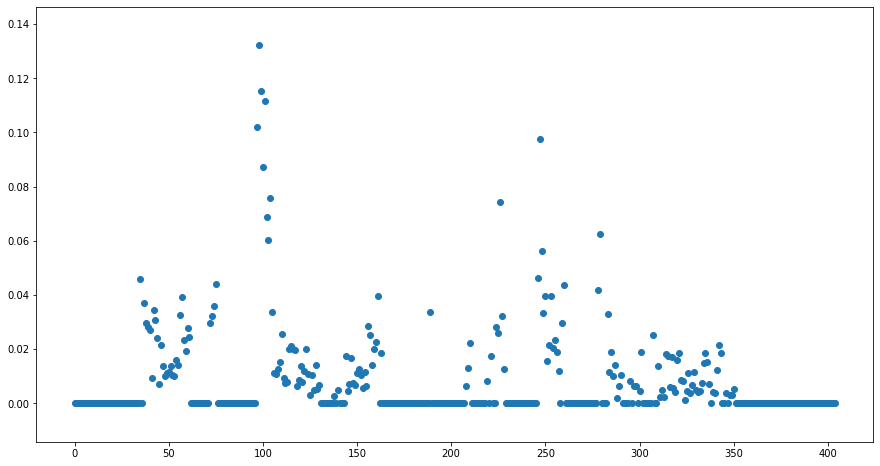

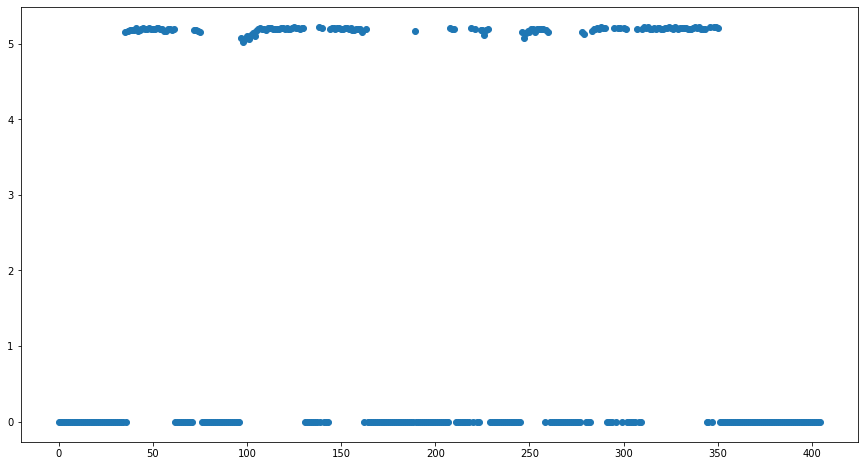

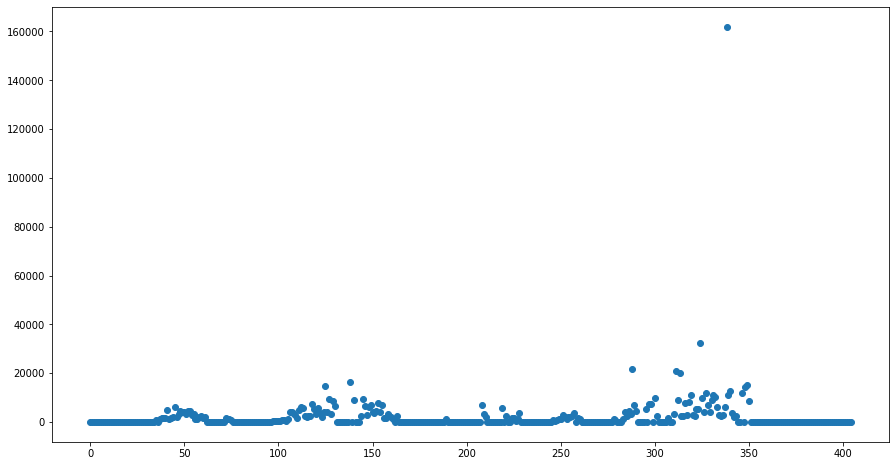

In [14]:
x = []
for i in range(len(files)):
    x.append(i)

plt.figure(figsize=(15,8))
plt.scatter(x, disparity)
plt.show()    

plt.figure(figsize=(15,8))
plt.scatter(x, testList)
plt.show()

plt.figure(figsize=(15,8))
plt.scatter(x, tL)
plt.show()

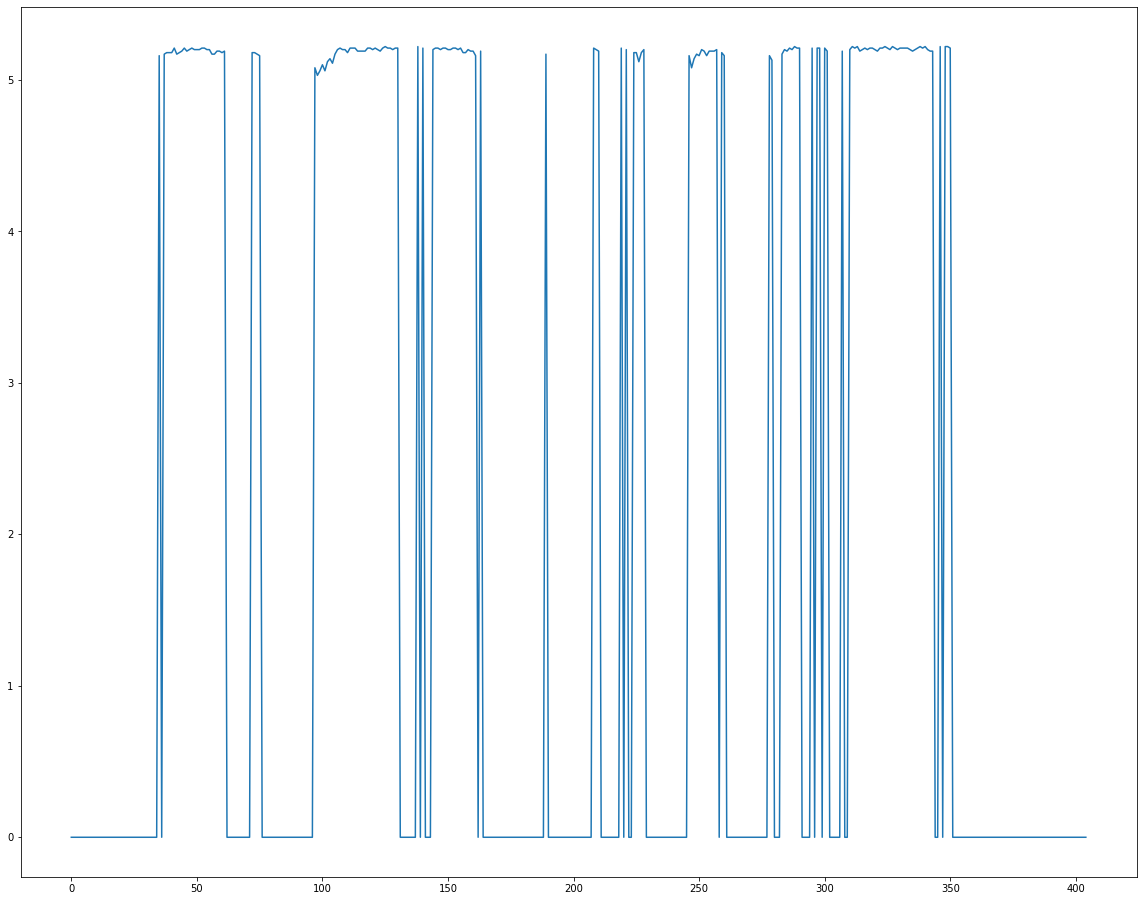

In [15]:
plt.figure(figsize=(20,16))
plt.plot(testList)
plt.show()

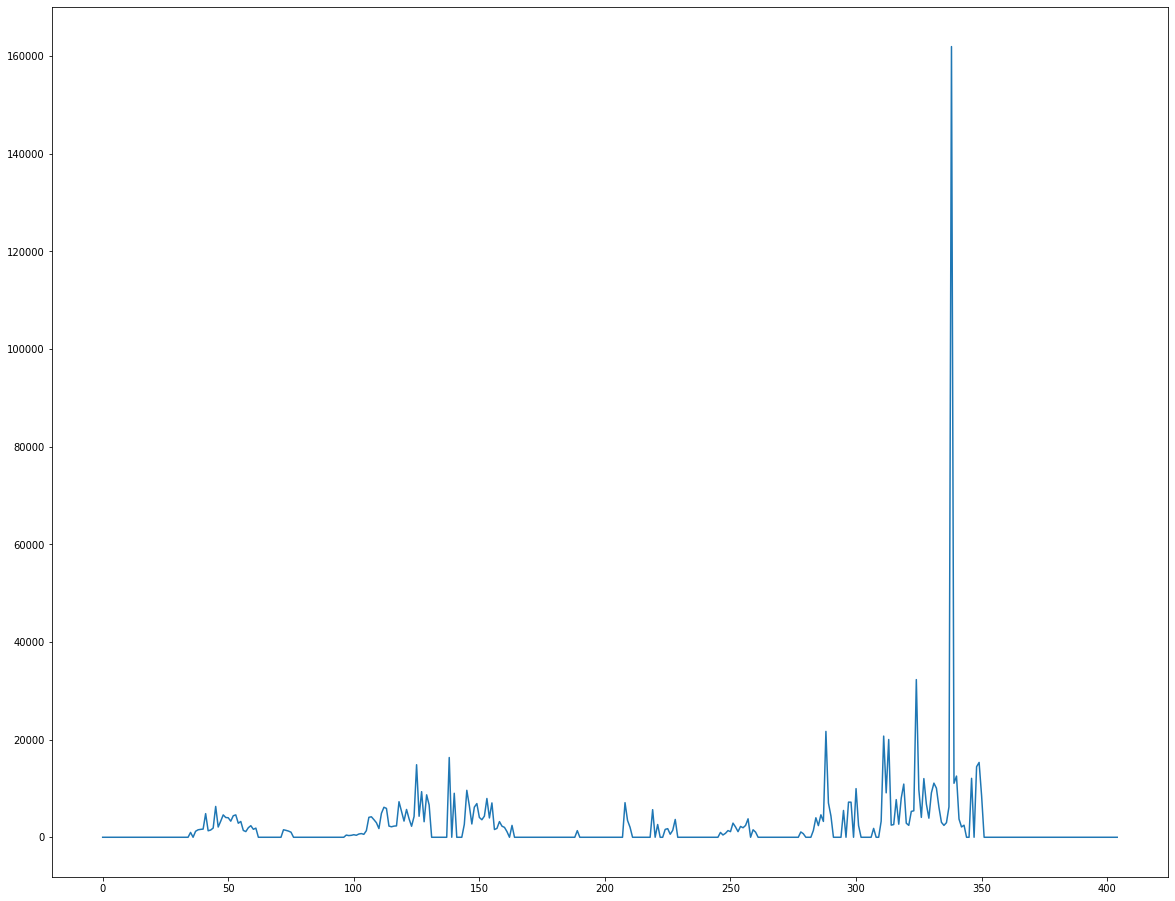

In [16]:
plt.figure(figsize=(20,16))
plt.plot(tL)
plt.show()

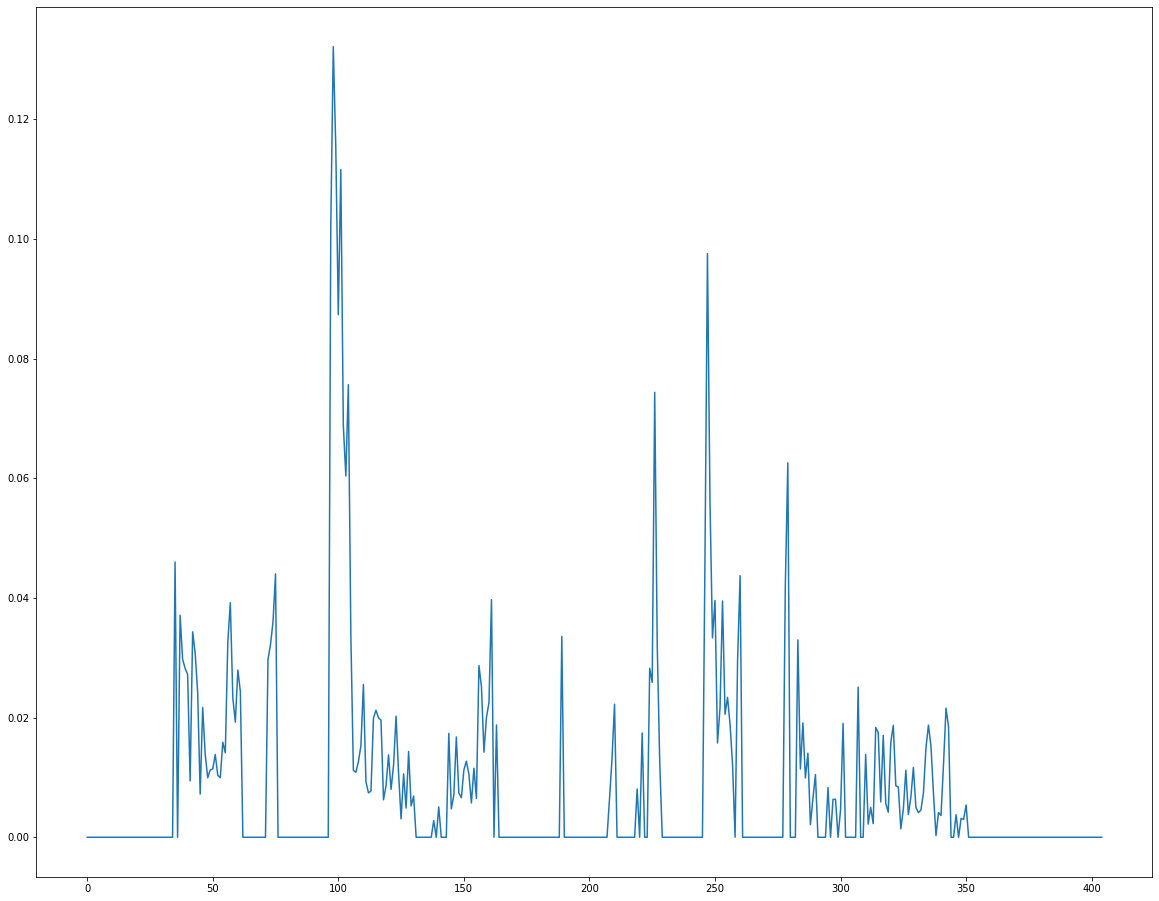

In [17]:
plt.figure(figsize=(20,16))
plt.plot(disparity)
plt.show()

In [18]:
disparity

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.046001785700024646,
 0,
 0.037095950595506584,
 0.029775365313530866,
 0.028223557624662315,
 0.027227836666106085,
 0.00942188910198556,
 0.03432719879977578,
 0.030766698605844665,
 0.024214519846485937,
 0.007223847720684553,
 0.021703790813503043,
 0.013855211565260832,
 0.009947267598992926,
 0.01126198698370426,
 0.011412828634833595,
 0.0138386269989065,
 0.010347403143717104,
 0.009949724662546988,
 0.015872089775406967,
 0.01410743507436814,
 0.03257019770185038,
 0.03919526376072264,
 0.02326484597767486,
 0.019238148449599594,
 0.027945431004040674,
 0.024353316406576855,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.02967237429722706,
 0.03223744317200734,
 0.03598550888784818,
 0.04401485250817821,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.10199454695842194,
 0.13213973245380084,
 0.11520846

In [19]:
for i in range(len(disparity)):
    print("Frame " + str(2*i+1) + " : " + str(disparity[i]))

Frame 1 : 0
Frame 3 : 0
Frame 5 : 0
Frame 7 : 0
Frame 9 : 0
Frame 11 : 0
Frame 13 : 0
Frame 15 : 0
Frame 17 : 0
Frame 19 : 0
Frame 21 : 0
Frame 23 : 0
Frame 25 : 0
Frame 27 : 0
Frame 29 : 0
Frame 31 : 0
Frame 33 : 0
Frame 35 : 0
Frame 37 : 0
Frame 39 : 0
Frame 41 : 0
Frame 43 : 0
Frame 45 : 0
Frame 47 : 0
Frame 49 : 0
Frame 51 : 0
Frame 53 : 0
Frame 55 : 0
Frame 57 : 0
Frame 59 : 0
Frame 61 : 0
Frame 63 : 0
Frame 65 : 0
Frame 67 : 0
Frame 69 : 0
Frame 71 : 0.046001785700024646
Frame 73 : 0
Frame 75 : 0.037095950595506584
Frame 77 : 0.029775365313530866
Frame 79 : 0.028223557624662315
Frame 81 : 0.027227836666106085
Frame 83 : 0.00942188910198556
Frame 85 : 0.03432719879977578
Frame 87 : 0.030766698605844665
Frame 89 : 0.024214519846485937
Frame 91 : 0.007223847720684553
Frame 93 : 0.021703790813503043
Frame 95 : 0.013855211565260832
Frame 97 : 0.009947267598992926
Frame 99 : 0.01126198698370426
Frame 101 : 0.011412828634833595
Frame 103 : 0.0138386269989065
Frame 105 : 0.01034740314371

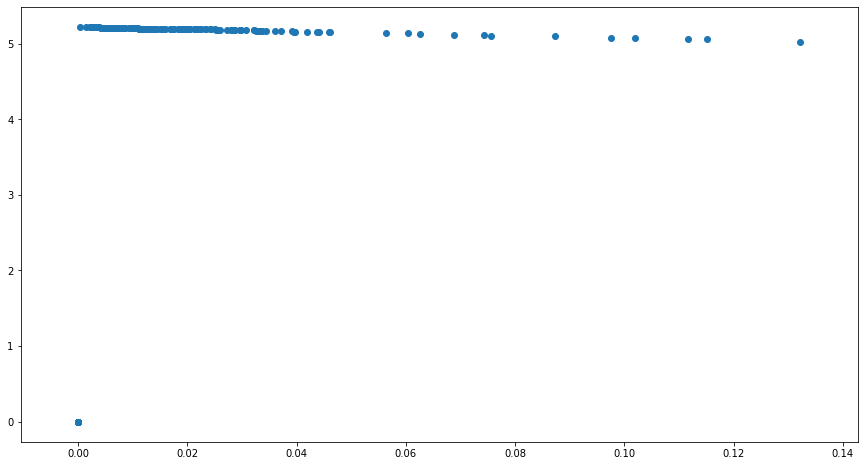

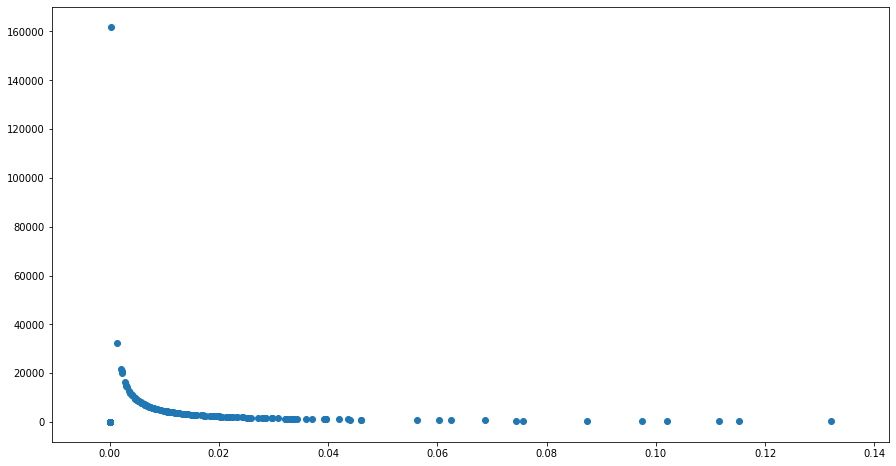

In [20]:
plt.figure(figsize=(15,8))
plt.scatter(disparity, testList)
plt.show()

plt.figure(figsize=(15,8))
plt.scatter(disparity, tL)
plt.show()